## Exploration with Word Embedings (Deep Learning)

### Anatomy of Word2Vec
* The input represents our vocabulary.
* The word embedding are actually the hidden layer after traning. This layer is set to the dimensionality of the resulting word vectors. 
* The output is the context given the word or the word given the context.
#### Note there is no activation function in the hidden layer which we refer to as linear activation.
<BR>
<img src="./images/word2vec.png" width=600>
<BR>
<img src="./images/w2v-contexts.png" width=600>
### Continuous Bag of Words (CBOW) Learning
#### Embedding Model p(word | context)
#### Advantages: Smooths over distribution by averaging over all context words. This is helpful for small training sets.
####                        Also faster
<BR>   
<img src="./images/CBOW.png" width="300"> 
### Skipgram 
#### Model p(context | word) 
#### Advantage: Learns finer-grained vectors on large training data (i.e. better with infrequent words)
<img src="./images/Skip-Gram.png" width=300>

In [18]:
import nltk
import pickle as pkl
import pandas as pd
import numpy as np
from string import punctuation
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import sklearn
from sklearn.manifold import TSNE
%matplotlib inline 
import matplotlib.pyplot as plt

## More Environment Setup

#### We also need to load some nltk resources. These resources will help us clean the data.

In [19]:
# Text contains a lot of noisy words that are simply there to help with fluency.
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jferraro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Syntactic NLP Processing

#### We want to coustomize tokenization so we have more control over our text and can remove unique textual forms of noise like dates, ages, etc.

In [3]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# turn a doc into clean tokens
def doc_to_clean_sentences(doc, vocab):
    clean_lines = list()
    lines = doc.splitlines()
    for line in lines:
        # split into tokens by white space
        tokens = line.lower().split()
        # remove punctuation from each token
        table = str.maketrans('', '', punctuation)
        tokens = [w.translate(table) for w in tokens]
        # filter out tokens not in vocab
        tokens = [w for w in tokens if w in vocab]
        if tokens:
            clean_lines.append(tokens)
    return clean_lines

## Get our Corpus and Vocabulary

#### Let's pull in our corpus that we had serialized out to disk.

In [4]:
file = open('data/differential-corpus.pkl','rb')
corpus = pkl.load(file)
file.close()

In [5]:
# load the vocabulary
vocab_filename = 'data\pna_vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

## Data Structure Transformation

#### Let's build a dataframe so we can select case types easily.

In [6]:
df = pd.DataFrame(columns=('case', 'document', 'label'))
for case, document in corpus.items():
    if 'PNA' in case:
        df = df.append({'case': case, 'document': document, 'label': 'PNA'}, ignore_index=True)
    elif 'COPD' in case:
        df = df.append({'case': case, 'document': document, 'label': 'COPD'}, ignore_index=True)
    else: # CHF
        df = df.append({'case': case, 'document': document, 'label': 'CHF'}, ignore_index=True) 
df.head()

case                                           document label
0  PNA1  \n\n\n     DATE: [**2996-12-2**] 10:25 AM\n   ...   PNA
1  PNA2  \n\n\n     DATE: [**2850-2-14**] 10:22 PM\n   ...   PNA
2  PNA3  \n\n\n     DATE: [**2631-10-3**] 9:52 AM\n    ...   PNA
3  PNA4  \n\n\n     DATE: [**2584-11-21**] 11:17 AM\n  ...   PNA
4  PNA5  \n\n\n     DATE: [**2584-11-21**] 11:17 AM\n  ...   PNA

## Building our Corpus

#### Using a data frame makes it easy to select between different cohorts.

In [7]:
df_pna = df.loc[df['label'] == 'PNA']
pneumonia_corpus = list()
for index, row in df_pna.iterrows():
        document = row['document']
        document_sentences = doc_to_clean_sentences(document, vocab)
        if document_sentences:
            pneumonia_corpus += document_sentences
print(pneumonia_corpus)

[['date'], ['ct', 'chest', 'wo', 'contrast', 'clip', 'clip', 'number', 'radiology'], ['reason', 'please', 'eval', 'loculated', 'pleural', 'effusion', 'right'], ['field', 'view'], ['underlying', 'medical', 'condition'], ['year', 'old', 'woman', 'ho', 'rul', 'subtotal', 'resection', 'lung', 'ca', 'well'], ['lll', 'superior', 'segment', 'resection', 'tb', 'presents', 'rll', 'pna'], ['parapneumonic', 'effusion', 'concerning', 'empyema'], ['reason', 'examination'], ['please', 'eval', 'loculated', 'pleural', 'effusion', 'right', 'place', 'pigtail'], ['catheter', 'send', 'fungal'], ['please', 'asap', 'pt', 'may', 'require', 'later'], ['final', 'report'], ['indication', 'previous', 'history', 'subtotal', 'resection', 'lung', 'cancer'], ['prior', 'left', 'lower', 'lobe', 'superior', 'segment', 'resection', 'tuberculosis'], ['currently', 'represents', 'right', 'lower', 'lobe', 'pneumonia', 'peripneumonic'], ['effusion', 'please', 'assess', 'pleural', 'effusion', 'evidence', 'empyema'], ['prior',

In [8]:
# train word2vec model
pneumonia_model = Word2Vec(pneumonia_corpus, size=200, window=5, workers=8, min_count=1)
# summarize vocabulary size in model
words = list(pneumonia_model.wv.vocab)

In [9]:
print(pneumonia_model)

Word2Vec(vocab=2619, size=200, alpha=0.025)


In [10]:
print("* * * * * Term vector for inflitrate\n")
print(pneumonia_model.wv['infiltrate'], "\n\n")

print("* * * * * Dictionary of term vectors\n")
w2v = dict(zip(pneumonia_model.wv.index2word, pneumonia_model.wv.syn0))
for keys,values in w2v.items():
    print(keys)
    print(values)

* * * * * Term vector for inflitrate

[-0.11987824  0.21995382 -0.07662853 -0.48715386 -0.21556066  0.18566726
  0.01925352 -0.12223253 -0.6163016  -0.48107058 -0.10632027 -0.07664324
  0.15450568  0.0570419   0.24897985 -0.00437877  0.09498256  0.0100292
  0.42579907 -0.22896002 -0.14525804  0.3020989   0.09135357 -0.14415018
 -0.361075   -0.29407355 -0.08974142 -0.2624938   0.06347523 -0.11094957
  0.2569939   0.05838469 -0.03849645  0.1111386  -0.13818799  0.18851872
  0.10936186 -0.18284151 -0.00235905 -0.26962966  0.07320134  0.28054592
 -0.32279354  0.02299825  0.16239259  0.02896587  0.32953188 -0.4946003
 -0.38331857 -0.19851063 -0.03538245  0.09363255  0.02856765 -0.2778744
 -0.08584655 -0.18241508  0.07858907 -0.22688341 -0.14275447  0.07158561
 -0.44508803 -0.28900412  0.08974504  0.00874866 -0.08820867 -0.15541399
  0.06337158  0.33525723  0.06634728 -0.19220856 -0.00638089 -0.04540153
  0.11259822  0.14089066 -0.21114857  0.35659564 -0.10310286 -0.02657889
  0.3128497   0.

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """



[ 0.08880907  0.09492738 -0.07466251 -0.6666105  -0.16999967  0.157068
 -0.11940638 -0.11462128 -0.6194077  -0.42707276  0.04795784 -0.04238776
  0.10247333 -0.02811097  0.25580496  0.15847145  0.07766536  0.09077163
  0.27351394 -0.17793714  0.03675597  0.20865521 -0.06290461 -0.2531203
 -0.43342668 -0.21656682 -0.18077968 -0.22452353  0.12603907 -0.29315156
  0.15525492  0.13189888 -0.00571631  0.30117473 -0.33283064  0.13753505
  0.08902193 -0.1173164  -0.07753888 -0.11077861  0.06183483  0.12627293
 -0.14516787  0.01651923  0.21417263 -0.07415546  0.17396909 -0.5414938
 -0.46972418 -0.07519154 -0.09610125  0.06159644  0.00632141 -0.15472694
 -0.1001123  -0.0840581   0.05483863 -0.16633739 -0.16458488  0.11506435
 -0.38927284 -0.40640873  0.17876098  0.07393145 -0.00382118 -0.03018257
  0.10166854  0.32888934  0.00594935 -0.21009012 -0.00393475 -0.07748727
  0.28166533  0.24844725 -0.09727353  0.27079064 -0.03112852 -0.02444763
  0.28597593  0.09438751 -0.11920325 -0.4981533  -0.10

mm
[-0.06686238  0.04975815 -0.15925667 -0.4530891  -0.14092238  0.04204719
 -0.0669595  -0.13552158 -0.54712427 -0.4099283  -0.01939201  0.03331309
  0.04750906 -0.17123763  0.20074882  0.19920552  0.34398967  0.04026571
  0.19549584 -0.28659293 -0.14692917  0.1840806  -0.16092873 -0.24417806
 -0.44797656 -0.11307918 -0.22776544 -0.14387234  0.00457956 -0.32192
  0.08094627  0.14564882 -0.00554     0.25840864 -0.25365523  0.0572903
 -0.10213717 -0.02694356  0.05485075 -0.26727808  0.17569394  0.06826241
 -0.24721806  0.03411066  0.29540768 -0.15807566 -0.07366939 -0.3441078
 -0.34570068 -0.13396335 -0.08256882  0.08481228 -0.10986401 -0.08866144
 -0.1499706  -0.07017519  0.07729647 -0.09866948 -0.20620936  0.14135702
 -0.25843185 -0.3168965   0.04981696  0.23921789 -0.00580971  0.08221015
  0.14328766  0.33163464  0.22341505  0.10560297 -0.1627049  -0.1327296
  0.15147057  0.22029603 -0.01916923  0.13458644  0.2329456  -0.01963352
  0.370807    0.00647211  0.00475394 -0.47749162 -0.33

  2.51473077e-02  9.65743959e-02  2.91676998e-01 -2.12390572e-01]
abd
[-0.14928296 -0.04077544 -0.1727726  -0.02007077 -0.00279712 -0.02241227
 -0.01087517 -0.00708436 -0.1777884  -0.1735024  -0.05327002  0.12201824
 -0.08505949 -0.24692059  0.06488887  0.09055965  0.31978112  0.02108827
 -0.01798688 -0.18462306 -0.18565294  0.01168555 -0.1887555  -0.09512676
 -0.16923377  0.01205484 -0.11736044 -0.00967028  0.03203094 -0.17756878
 -0.01939634  0.13936906  0.01243312  0.1533457  -0.03444703 -0.02669364
 -0.22514035  0.02094049  0.12864938 -0.22387049  0.17111893 -0.00126475
 -0.10879399  0.048359    0.28951976 -0.18477297 -0.19715908  0.02481303
 -0.10921979 -0.09047245 -0.04621306  0.11817525 -0.1084158   0.00768786
 -0.06966541 -0.04636824  0.03096144  0.00707526 -0.1305159   0.10904216
 -0.00185927 -0.04969692 -0.04336378  0.28813866  0.02730186  0.12111173
  0.122397    0.19602874  0.19706436  0.258763   -0.17574629 -0.13600503
  0.01897904  0.06199387  0.02308936 -0.0172384   0.30

additionally
[-2.87474133e-02  3.98770757e-02 -7.15165809e-02 -2.57331550e-01
 -7.61093274e-02  4.73322645e-02 -3.66724506e-02 -5.62073365e-02
 -2.99947917e-01 -2.27430835e-01 -4.59243031e-03  1.48905665e-02
  2.62898002e-02 -6.39946908e-02  1.17537327e-01  9.16740596e-02
  1.40834883e-01  4.20686081e-02  1.21386096e-01 -1.46700680e-01
 -5.64484745e-02  1.08793326e-01 -5.97289428e-02 -1.24007247e-01
 -2.21953616e-01 -8.79500359e-02 -1.08552478e-01 -9.00280103e-02
  2.93153245e-02 -1.57855436e-01  5.26693799e-02  7.60283023e-02
 -3.58342333e-03  1.49936900e-01 -1.43071458e-01  5.72653413e-02
 -3.69752944e-02 -3.33933197e-02  8.76555126e-03 -1.19616553e-01
  7.28341565e-02  5.54370359e-02 -1.16706863e-01  1.21970056e-02
  1.53936371e-01 -7.93104470e-02  2.67844796e-02 -2.14471623e-01
 -1.98862642e-01 -6.13245927e-02 -4.46002334e-02  5.27345017e-02
 -4.95014973e-02 -6.49588555e-02 -5.39162233e-02 -4.82607484e-02
  3.72292995e-02 -6.67497590e-02 -9.51482207e-02  7.14123324e-02
 -1.57723680

iliac
[-1.73864737e-02  2.72664931e-02 -7.41777197e-02 -2.36655846e-01
 -6.46070316e-02  3.11024245e-02 -3.52374986e-02 -5.65462895e-02
 -2.80470252e-01 -2.05309063e-01  1.15658541e-03  1.67111754e-02
  1.91596784e-02 -7.67322257e-02  1.01721704e-01  9.22659785e-02
  1.47982076e-01  3.65656465e-02  9.45690945e-02 -1.38152465e-01
 -5.74495047e-02  9.45221931e-02 -7.92521015e-02 -1.17876500e-01
 -2.11710095e-01 -6.65384158e-02 -1.12198688e-01 -8.01815018e-02
  2.13765558e-02 -1.66762874e-01  3.66719551e-02  7.31743500e-02
 -1.54104969e-03  1.49606973e-01 -1.35694280e-01  3.81943621e-02
 -3.97438630e-02 -2.11305227e-02  1.48444045e-02 -1.09473474e-01
  6.89393505e-02  3.40364985e-02 -1.04450956e-01  1.91044174e-02
  1.49856389e-01 -8.25940296e-02 -9.11424309e-03 -1.93520904e-01
 -1.83107272e-01 -5.18767834e-02 -4.26576883e-02  4.77735512e-02
 -5.60075901e-02 -4.87021171e-02 -5.70469573e-02 -4.14157063e-02
  4.54468690e-02 -5.67089245e-02 -9.70027149e-02  7.51286820e-02
 -1.39064178e-01 -1

[-1.09607698e-02  1.64174978e-02 -5.42388149e-02 -1.47285491e-01
 -3.41017842e-02  1.37399957e-02 -2.53577400e-02 -3.69239785e-02
 -1.86678052e-01 -1.32352889e-01 -1.73694832e-04  1.32758198e-02
  5.66438865e-03 -4.95558344e-02  6.82288185e-02  6.67189136e-02
  1.10335737e-01  2.92852037e-02  4.98387963e-02 -9.56840962e-02
 -3.90494652e-02  6.22018166e-02 -6.51510879e-02 -8.21649358e-02
 -1.48439422e-01 -3.80615629e-02 -7.78947026e-02 -4.32862118e-02
  1.25905741e-02 -1.23130552e-01  1.63985435e-02  5.18472865e-02
 -4.70771501e-03  9.99159887e-02 -9.41883996e-02  2.07171496e-02
 -3.29563990e-02 -9.76450555e-03  1.35996379e-02 -7.74775743e-02
  4.59361337e-02  1.32814748e-02 -7.33440593e-02  1.72183812e-02
  1.00454353e-01 -6.83799610e-02 -2.50740349e-02 -1.19551197e-01
 -1.13550767e-01 -3.18543240e-02 -2.95885727e-02  3.42779979e-02
 -4.56194058e-02 -2.51652524e-02 -3.34667973e-02 -2.90829949e-02
  3.26659568e-02 -2.73625981e-02 -6.77748173e-02  4.55444716e-02
 -9.00962651e-02 -1.03781

 -2.20676567e-02  2.27160845e-02  1.55491859e-01 -1.18826598e-01]
intra
[-0.02692498  0.02108208 -0.04718217 -0.13124913 -0.04110066  0.01457932
 -0.01809312 -0.03630802 -0.16251233 -0.12674853 -0.00490819  0.01220741
  0.01686186 -0.04653028  0.06495961  0.05046964  0.09119686  0.01173663
  0.06053728 -0.08832401 -0.04811629  0.05611561 -0.04081853 -0.06800758
 -0.12189489 -0.03630699 -0.05584586 -0.04881234  0.00812283 -0.08812304
  0.02967307  0.03414234 -0.00069088  0.07523136 -0.07075843  0.02475552
 -0.02481686 -0.0152683   0.01531944 -0.07663914  0.04836275  0.02850595
 -0.07072189  0.01279745  0.08703541 -0.03680736 -0.00886975 -0.09985621
 -0.09954625 -0.03707658 -0.02545642  0.03009362 -0.02906915 -0.03209841
 -0.0385439  -0.02728017  0.0258206  -0.03541789 -0.05349106  0.04477017
 -0.08157974 -0.0924596   0.01564982  0.06678355 -0.00703474  0.01368751
  0.04357487  0.09736647  0.05646159  0.02453444 -0.03893768 -0.03655671
  0.04700364  0.05971311 -0.01532342  0.04617397  0.

duct
[-0.04908473  0.01930214 -0.0831573  -0.16805887 -0.0586245   0.01136285
 -0.02414743 -0.04868761 -0.22724693 -0.17416301 -0.00795452  0.02119615
  0.02134881 -0.07762855  0.08471328  0.07632978  0.15287209  0.01716813
  0.07807475 -0.13195722 -0.08531431  0.07314217 -0.06865522 -0.09872692
 -0.18029688 -0.04150737 -0.08131258 -0.06381101  0.00949472 -0.1307546
  0.03708504  0.04513779  0.00080299  0.10266806 -0.09175926  0.02409894
 -0.04865187 -0.01480035  0.03491841 -0.1171127   0.07166769  0.03699189
 -0.10718514  0.02092024  0.13403645 -0.06219322 -0.04188138 -0.12392343
 -0.1347372  -0.05687249 -0.03407187  0.04629197 -0.04485145 -0.03567157
 -0.0655264  -0.03061772  0.0422095  -0.03976019 -0.07996272  0.06799423
 -0.11650037 -0.12456711  0.01820838  0.10563296 -0.00623024  0.027909
  0.07235312  0.1470902   0.0945964   0.06239577 -0.06708098 -0.06387003
  0.06113826  0.08524014 -0.01390881  0.05753015  0.10049615 -0.0067861
  0.15669897  0.00340662  0.00980821 -0.18888603 -

 -5.37390297e-04  2.97933314e-02  1.13931060e-01 -9.54083800e-02]
borders
[-1.49644231e-02  1.21485656e-02 -2.58449875e-02 -7.58923516e-02
 -2.48990525e-02  5.21743344e-03 -1.41053656e-02 -2.21554637e-02
 -9.01096240e-02 -6.86338991e-02 -1.05853355e-03  1.08500021e-02
  8.53014924e-03 -2.83613298e-02  3.76118198e-02  3.38495784e-02
  5.64489737e-02  8.42025969e-03  3.15510780e-02 -4.96599972e-02
 -2.87168082e-02  3.38681303e-02 -2.58248579e-02 -3.96349356e-02
 -7.26574212e-02 -2.09686644e-02 -3.59369554e-02 -2.31635924e-02
  1.79268874e-03 -5.22056296e-02  1.47009930e-02  2.35960875e-02
  8.33563972e-04  4.25906032e-02 -4.40155789e-02  1.27331782e-02
 -2.16868520e-02 -6.48185518e-03  6.44474570e-03 -4.44195755e-02
  2.74307337e-02  1.41198477e-02 -4.05193008e-02  5.99196786e-03
  4.96983230e-02 -2.89690979e-02 -8.16480909e-03 -5.27749956e-02
 -5.70110157e-02 -1.91960260e-02 -1.50446296e-02  1.93986036e-02
 -2.01083254e-02 -1.53092919e-02 -2.33633146e-02 -1.18290223e-02
  1.23175262e-02

[-0.0058231   0.01009415 -0.02997219 -0.05930718 -0.01622656  0.0077018
 -0.00985991 -0.01162388 -0.08408912 -0.06144532  0.00041754  0.00659277
  0.00220369 -0.02638075  0.02971643  0.02992619  0.04974321  0.01537173
  0.02496476 -0.04696755 -0.02378546  0.02610067 -0.02762679 -0.03620644
 -0.06691656 -0.01842891 -0.03195668 -0.01876657  0.00813352 -0.05306087
  0.00790207  0.02070783 -0.00032679  0.04630137 -0.04348749  0.0071657
 -0.02090158 -0.0020584   0.00863942 -0.04070624  0.02404152  0.00560832
 -0.03356547  0.00778473  0.04775187 -0.02913319 -0.0134451  -0.05019537
 -0.05007993 -0.0150021  -0.01128878  0.02132262 -0.01859685 -0.01280044
 -0.01682523 -0.01274669  0.01164305 -0.0096612  -0.03320618  0.02543518
 -0.04090358 -0.04168562  0.00587438  0.04049388  0.00790322  0.01447905
  0.01735731  0.05083862  0.02665541  0.01800681 -0.0195516  -0.01937954
  0.03209508  0.03025042  0.00284117  0.02098399  0.03846821 -0.0038277
  0.05301861 -0.00087416 -0.00101467 -0.0703747  -0.04

oxygenation
[-1.11907544e-02  7.28103984e-03 -1.72520485e-02 -4.24150787e-02
 -1.29213175e-02  4.49746847e-03 -3.24683194e-03 -1.35248378e-02
 -4.99621294e-02 -4.21579704e-02 -2.68795714e-03  1.29197247e-03
  8.70653521e-03 -1.67572238e-02  1.90625507e-02  1.45370392e-02
  3.46597210e-02  2.61862599e-03  1.94218792e-02 -2.83247922e-02
 -2.11271700e-02  1.68875884e-02 -1.44419875e-02 -2.24511977e-02
 -4.39930484e-02 -1.16324443e-02 -1.93772111e-02 -1.96049716e-02
  9.45888605e-05 -2.51116864e-02  1.16620976e-02  8.66211299e-03
 -1.04441005e-03  1.99638978e-02 -1.71722695e-02  6.24726294e-03
 -4.03583422e-03 -5.47783496e-03  7.34778307e-03 -2.96328347e-02
  1.69755537e-02  1.12292171e-02 -2.96690483e-02  3.72353918e-03
  2.81629730e-02 -8.39411560e-03 -4.85688308e-03 -3.07097472e-02
 -3.24851349e-02 -1.61365010e-02 -6.66279206e-03  8.68174154e-03
 -4.89428453e-03 -1.11410283e-02 -1.72891151e-02 -8.45625158e-03
  1.15748858e-02 -1.11496048e-02 -1.75175052e-02  1.19203804e-02
 -2.87942998e

suspect
[-0.02684076  0.01241318 -0.04106288 -0.0899609  -0.03217264  0.00746044
 -0.00902032 -0.03054413 -0.11884215 -0.09753007 -0.01021823  0.01186858
  0.01176176 -0.04214681  0.0484479   0.03980444  0.08467146  0.00510515
  0.04278609 -0.07221397 -0.05124668  0.0428549  -0.03552832 -0.05410052
 -0.09776603 -0.02423467 -0.04646021 -0.03205712  0.00207204 -0.07056654
  0.0217384   0.02926335  0.00121045  0.05045656 -0.04465511  0.01277015
 -0.02904869 -0.00589636  0.0167533  -0.0670266   0.03958058  0.02009184
 -0.06323954  0.0112076   0.07123782 -0.03146333 -0.01782608 -0.06783354
 -0.07144701 -0.03112725 -0.01733311  0.02757061 -0.02700319 -0.01958665
 -0.03233332 -0.01657021  0.02025543 -0.02097574 -0.04122237  0.03669547
 -0.06195633 -0.06783973  0.008642    0.05610733 -0.0037509   0.01473454
  0.03939674  0.07716078  0.05459405  0.03546149 -0.03744123 -0.03355154
  0.02921819  0.04644477 -0.01108273  0.02757692  0.05397483 -0.00523342
  0.08844279  0.00356668  0.00995663 -0.102

 -1.79819076e-03  1.22840367e-02  3.57645564e-02 -2.87101045e-02]
respond
[-0.02164526  0.01163667 -0.01870554 -0.06901028 -0.0250168   0.00782452
 -0.00043371 -0.02412279 -0.07806174 -0.0667339  -0.00724277  0.00338623
  0.01270924 -0.02440498  0.02997617  0.02072644  0.04935496  0.00207913
  0.03186243 -0.0467601  -0.03597654  0.02930524 -0.01089896 -0.03295992
 -0.06370301 -0.01874382 -0.03305763 -0.02762764 -0.00399186 -0.03767272
  0.0237617   0.01893452  0.0043711   0.02385537 -0.02242732  0.0117548
 -0.0049699  -0.00438909  0.01467982 -0.04507967  0.03188202  0.02264019
 -0.04728653  0.01068574  0.04349623 -0.01372363  0.00070475 -0.05652212
 -0.05579548 -0.02889718 -0.01077766  0.00781048 -0.00970624 -0.02115341
 -0.02902955 -0.01350347  0.01281618 -0.02300539 -0.0319695   0.02034771
 -0.04826097 -0.05152746  0.00917772  0.03019272 -0.01521516  0.00357643
  0.02726956  0.04992918  0.03587073  0.01165841 -0.02618197 -0.02266691
  0.01184854  0.02811221 -0.01670814  0.0228543   0

[-0.01167812  0.00072267 -0.0020355  -0.01140173 -0.00211571  0.00298484
  0.0038003  -0.00810584 -0.01284767 -0.01296621 -0.01006058 -0.00220625
  0.00218213 -0.01532974  0.0062655   0.00217533  0.01481073 -0.00518598
  0.00409746 -0.00861144 -0.01579248  0.00386952  0.00071648 -0.00942074
 -0.00862119  0.00043697 -0.00773603 -0.00703051 -0.00565484 -0.00140967
  0.00605975  0.00583879  0.00280398 -0.00287736  0.0030941   0.0033331
 -0.00522448  0.00197778  0.01127653 -0.01658725  0.01725138  0.01143866
 -0.0144777   0.00399083  0.01867818 -0.00139427 -0.00366618 -0.00686576
 -0.00853869 -0.01251572 -0.0004024   0.0024893  -0.00222656 -0.00325831
 -0.009674   -0.0019421   0.0027704  -0.00722604 -0.00978134  0.00431671
 -0.00255261 -0.01248016 -0.00305855  0.01141702 -0.00771794 -0.00074688
  0.01012584  0.00919892  0.01623646  0.00908276 -0.01181579 -0.00951257
 -0.00576958  0.00627615 -0.00704389 -0.00059759  0.01273787  0.00211916
  0.0160263   0.00447006  0.00795266 -0.0122635  -0.

cant
[-0.0137948   0.00761756 -0.01668707 -0.06082653 -0.01787301  0.0081713
 -0.00350973 -0.01577725 -0.07046655 -0.05730438 -0.00245779  0.00453322
  0.00947373 -0.02071451  0.02872682  0.02131707  0.03743796  0.00483253
  0.03086412 -0.03695296 -0.02222154  0.02461579 -0.01366697 -0.03204396
 -0.05311687 -0.01982039 -0.02630985 -0.02343717 -0.00032841 -0.03247842
  0.01783688  0.01484864 -0.00156997  0.02533902 -0.02789691  0.0110333
 -0.00635673 -0.00730471  0.00907296 -0.03662244  0.01962951  0.01767048
 -0.03537041  0.00367929  0.03975    -0.01122206  0.00251428 -0.04784237
 -0.04527692 -0.01738457 -0.01192256  0.01113734 -0.0091227  -0.01634048
 -0.01819993 -0.01122939  0.01185707 -0.01807874 -0.02197102  0.01979961
 -0.03774258 -0.04238371  0.00624402  0.02459532 -0.00744166  0.00486726
  0.01889187  0.04377572  0.02795999  0.00886236 -0.02018017 -0.02111601
  0.01523592  0.02862097 -0.01117716  0.02359461  0.02300728  0.00219455
  0.04776887  0.00598979  0.00240526 -0.05704062

swan
[-0.0061371   0.00199569 -0.01829338 -0.02864077 -0.00722625 -0.00052836
 -0.00396362 -0.00909264 -0.0411388  -0.03267627  0.0003117   0.0030123
  0.00111563 -0.0130294   0.0129011   0.01369705  0.0286229   0.00556434
  0.0088196  -0.02754101 -0.01471748  0.01220423 -0.01240049 -0.01683815
 -0.03286549 -0.00535317 -0.01791201 -0.01258201  0.00149055 -0.02504328
  0.00150209  0.01032907 -0.00068551  0.01815828 -0.01847844  0.00585004
 -0.01009097 -0.00197857  0.00550743 -0.02216303  0.0113897   0.00566638
 -0.01834982  0.00315839  0.02541957 -0.01402289 -0.00871122 -0.02409985
 -0.02480493 -0.0058184  -0.00580088  0.0081284  -0.01042268 -0.00659375
 -0.00851574 -0.00865988  0.00468516 -0.00596755 -0.01313762  0.01496288
 -0.02265407 -0.02253463  0.00229694  0.02087743  0.00140508  0.01079137
  0.01064963  0.02677218  0.01703169  0.01306726 -0.01275935 -0.01221922
  0.0127447   0.01455975 -0.00037099  0.00981291  0.01861209 -0.00381645
  0.02637738  0.00072887  0.00059242 -0.0325224

 -3.84011422e-03  3.69266490e-03  2.06266548e-02 -1.44797685e-02]
fatcontaining
[ 1.9134451e-03 -1.0741578e-03 -5.3287465e-03 -5.5851266e-03
  1.3813803e-03  1.0743991e-03 -5.8820297e-04 -3.7134760e-03
 -6.1501772e-03 -4.9506081e-03 -9.8820427e-04 -9.7274972e-04
 -1.8184985e-03  2.3226711e-04  6.7053821e-05  2.7526729e-03
  5.9371213e-03  2.5759221e-03  1.2279578e-03 -2.0775024e-03
 -3.1837455e-03  1.5624447e-04 -2.0128775e-03 -1.8949655e-03
 -5.1778862e-03 -2.9846563e-03 -1.9860559e-03 -3.0152295e-03
  1.5555234e-03 -4.0063318e-03 -7.4510800e-04  3.4422344e-03
 -5.3118571e-04  4.9353675e-03 -5.0094514e-03  1.1777807e-03
 -1.2202702e-03  1.5105770e-03  5.7184097e-04 -3.6018924e-03
  8.5541967e-04  9.4056246e-04 -3.5516208e-03  1.8705567e-03
  5.8084838e-03 -1.5993800e-03 -2.4751094e-03 -4.2481958e-03
 -4.3092673e-03  8.6590601e-04 -1.9509776e-03  2.2673525e-03
 -2.4166093e-03 -3.2328605e-04  2.7435523e-04 -3.9308942e-03
  2.5781526e-03 -2.5737475e-04 -1.7850428e-03 -3.3988501e-04
 -2.2

  2.24234583e-03  4.58019407e-04 -2.35803123e-03 -1.73513021e-03]
dvt
[-6.05848525e-03  5.86610660e-03 -1.08537637e-02 -2.38434207e-02
 -6.26346841e-03  4.07283101e-03 -5.02076978e-03 -4.19412274e-03
 -3.04120276e-02 -2.75839549e-02  6.16158999e-04  8.67002003e-04
  2.75777513e-03 -7.35715311e-03  1.46434382e-02  1.05634434e-02
  1.79990176e-02  4.16065753e-03  1.38287013e-02 -1.97492875e-02
 -1.11564063e-02  1.36488881e-02 -8.26505665e-03 -1.18751051e-02
 -2.28180997e-02 -9.89274774e-03 -1.33961644e-02 -1.01910830e-02
  3.06668016e-03 -1.59862768e-02  5.02026360e-03  8.26388691e-03
 -1.61534629e-03  1.32232234e-02 -1.32723656e-02  4.76538390e-03
 -2.50028097e-03 -4.37494926e-03  4.60870052e-03 -1.41965728e-02
  8.66633188e-03  8.10840353e-03 -1.35903619e-02  6.58994366e-04
  1.62592735e-02 -7.54898181e-03 -2.63442472e-03 -2.28513461e-02
 -1.92395169e-02 -6.81649009e-03 -5.24991564e-03  4.91651846e-03
 -8.21739435e-03 -4.13271505e-03 -7.55945453e-03 -3.31592979e-03
  7.06765242e-03 -8.

flexed
[-1.00340117e-02  1.72873866e-03 -1.53756747e-02 -2.58041713e-02
 -9.23520699e-03  3.80976795e-04 -5.09099849e-03 -6.14289567e-03
 -3.79217751e-02 -3.33672501e-02  1.86980376e-03  4.02835431e-03
  9.55762167e-04 -1.38860773e-02  1.59410387e-02  1.38995117e-02
  3.02835386e-02  5.43543231e-03  1.09864678e-02 -2.42277291e-02
 -1.48100806e-02  1.23991631e-02 -1.44977197e-02 -1.51857007e-02
 -3.05232760e-02 -3.88351991e-03 -1.66983847e-02 -1.08873667e-02
 -2.61296256e-04 -2.42730957e-02  4.97653708e-03  6.96518691e-03
  1.44343544e-03  2.16098577e-02 -1.66660622e-02  2.93876580e-03
 -1.23576997e-02 -3.09064891e-03  4.58073243e-03 -2.21242644e-02
  1.27969515e-02  4.24402440e-03 -2.12292038e-02  5.16718999e-03
  2.17094049e-02 -1.57019272e-02 -1.18096992e-02 -2.00650357e-02
 -2.41345856e-02 -1.12122325e-02 -4.88702022e-03  1.14255752e-02
 -9.85296071e-03 -5.39182965e-03 -1.15760155e-02 -6.18132204e-03
  5.62318321e-03 -4.19592112e-03 -1.29765216e-02  1.40745193e-02
 -1.90724507e-02 -

In [11]:
print("bilateral")
print(pneumonia_model.wv.most_similar(positive = ['bilateral'], topn=20), "\n")

print("\npneumonia")
print(pneumonia_model.wv.most_similar(positive = ['pneumonia'], topn=20), "\n")

print("\nNot pneumonia")
print(pneumonia_model.wv.most_similar(negative = ['pneumonia'], topn=20), "\n")

print("\nRelationship pneumonia disimular to CHF with infiltrate")
print(pneumonia_model.wv.most_similar(positive=["pneumonia", "infiltrate"], negative=["chf"]), "\n")


bilateral
[('effusions', 0.9979709386825562), ('pleural', 0.9974550008773804), ('effusion', 0.99690181016922), ('patchy', 0.9925715327262878), ('opacities', 0.9898556470870972), ('effusionspleural', 0.9896180629730225), ('greater', 0.989084005355835), ('atelectasis', 0.9880004525184631), ('space', 0.9863666892051697), ('loculated', 0.9851855039596558), ('base', 0.9830681085586548), ('consolidation', 0.9830312728881836), ('small', 0.980153501033783), ('opacity', 0.9799268841743469), ('opacifications', 0.9799209237098694), ('increased', 0.9788907170295715), ('lingular', 0.978290855884552), ('left', 0.9782225489616394), ('middle', 0.9777219295501709), ('areas', 0.9773833751678467)] 


pneumonia
[('chf', 0.987767219543457), ('rll', 0.9866062998771667), ('worsening', 0.9840185642242432), ('multifocal', 0.9802278876304626), ('yearold', 0.9782572984695435), ('rr', 0.974757194519043), ('failure', 0.9745112061500549), ('vs', 0.9713605642318726), ('lll', 0.9665048718452454), ('evolution', 0.9653

D:\anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [13]:
print("(Opacities and Infiltrates): ", pneumonia_model.wv.similarity("opacities", "infiltrates"))

print("(Effusions and Pneumonia)", pneumonia_model.wv.similarity("effusions", "pneumonia"))

(Opacities and Infiltrates):  0.915697
(Effusions and Pneumonia) 0.8568851


D:\anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [14]:
def plot_embeddings(w2v_model, vocabulary):
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    
    # Get the term vectors out of the model for the specified vocabulary
    term_vectors = []
    for term in vocabulary:
        if term in w2v_model.wv.vocab:
            term_vectors.append(w2v_model[term])
    Y = tsne.fit_transform(term_vectors)
    
    # let's make this plot a decent size...
    # Get current size
    fig_size = plt.rcParams["figure.figsize"]
    # Set figure width and height
    fig_size[0] = 20
    fig_size[1] = 20
    plt.rcParams["figure.figsize"] = fig_size
 
    plt.scatter(Y[:, 0], Y[:, 1])
    for label, x, y in zip(vocabulary, Y[:, 0], Y[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.show()

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


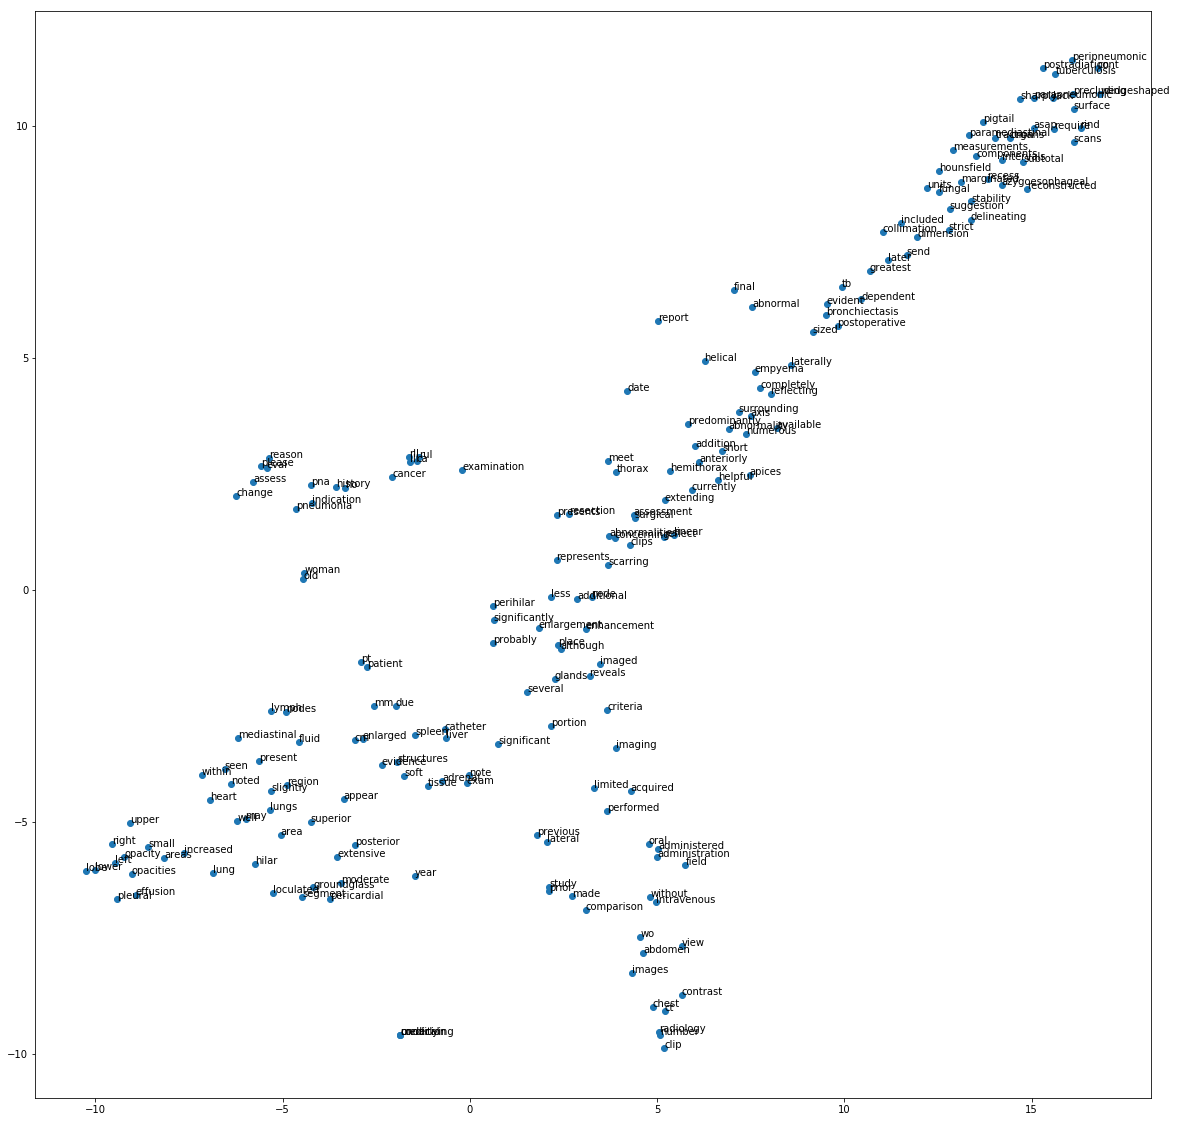

In [17]:
pneumonia_vocab = [k for (k, v) in pneumonia_model.wv.vocab.items()]
plot_embeddings(pneumonia_model, pneumonia_vocab[:200])